# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
path = Path('../../data/midi/v15/piano_duet/')

## Single Stream Encoding

In [9]:
config = v15m_config(vocab); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.2,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 139),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 274}

## Fastai Learner

In [10]:
# data = load_music_data(path, cache_name='tmp/sample', vocab=vocab, **config)
data = load_music_data(path/'tmp/sample', cache_name='', vocab=vocab, **config)

In [11]:
saved_models = get_files(path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v15/piano_duet/models/sample_train.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/tmp.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/sample_train_3.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/sample_train_2.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/sample_train_5.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/sample_train_4.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/save_s2s_1.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/unilm/all/1_ep24.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/v15m/hq/2_ep40_lowerlr.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/v15m/hq/1_ep40.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/v15m/hq/2_60_best.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/v15m/hq/1_ep40_best.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/v15m/hq/2_60.pth'),
 PosixPath('../../data/midi/v15/piano_duet/models/v15m/hq/2_ep40_

In [12]:
load_path = saved_models[-5]; load_path

PosixPath('../../data/midi/v15/piano_duet/models/v15m/hook_c/2_24.pth')

In [13]:
learn = load_music_learner(data, config.copy(), load_path)

False


In [14]:
# learn = music_model_learner(data, config.copy())

## Debugging prediction values

In [15]:
xb,yb = data.one_batch(cpu=False)

In [16]:
learn.pred_batch(batch=(xb,yb))

tensor([[[2.6005e-05, 6.6310e-06, 1.9868e-06,  ..., 1.9813e-06,
          1.9869e-06, 1.9891e-06],
         [1.0236e-04, 5.9577e-07, 1.2675e-07,  ..., 1.2500e-07,
          1.2617e-07, 1.2704e-07],
         [5.0271e-07, 1.8509e-07, 6.4480e-08,  ..., 6.4079e-08,
          6.4548e-08, 6.4964e-08],
         ...,
         [1.0518e-05, 1.6669e-06, 1.6093e-07,  ..., 1.6076e-07,
          1.6179e-07, 1.6083e-07],
         [3.0348e-07, 1.4310e-07, 3.0458e-08,  ..., 3.0143e-08,
          3.0467e-08, 3.0663e-08],
         [1.3543e-04, 2.9091e-08, 6.3267e-09,  ..., 6.2462e-09,
          6.2705e-09, 6.1853e-09]],

        [[2.6005e-05, 6.6310e-06, 1.9868e-06,  ..., 1.9813e-06,
          1.9869e-06, 1.9891e-06],
         [1.0236e-04, 5.9577e-07, 1.2675e-07,  ..., 1.2500e-07,
          1.2617e-07, 1.2704e-07],
         [5.0271e-07, 1.8509e-07, 6.4480e-08,  ..., 6.4079e-08,
          6.4548e-08, 6.4964e-08],
         ...,
         [1.0518e-05, 1.6669e-06, 1.6093e-07,  ..., 1.6076e-07,
          1.617

## Prediction

In [17]:
data_dir = 'data/midi/v15/'
source_dir = 'piano_duet'
file_path = Path('../../')

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory']; results.head()

,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
16596,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory


In [32]:
idx = 0
file = file_path/data_dir/results.numpy.values[idx]; 
# orig = file_path/data_dir/results.mxl.values[idx];
orig = file_path/data_dir/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_original.mid'))

In [40]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

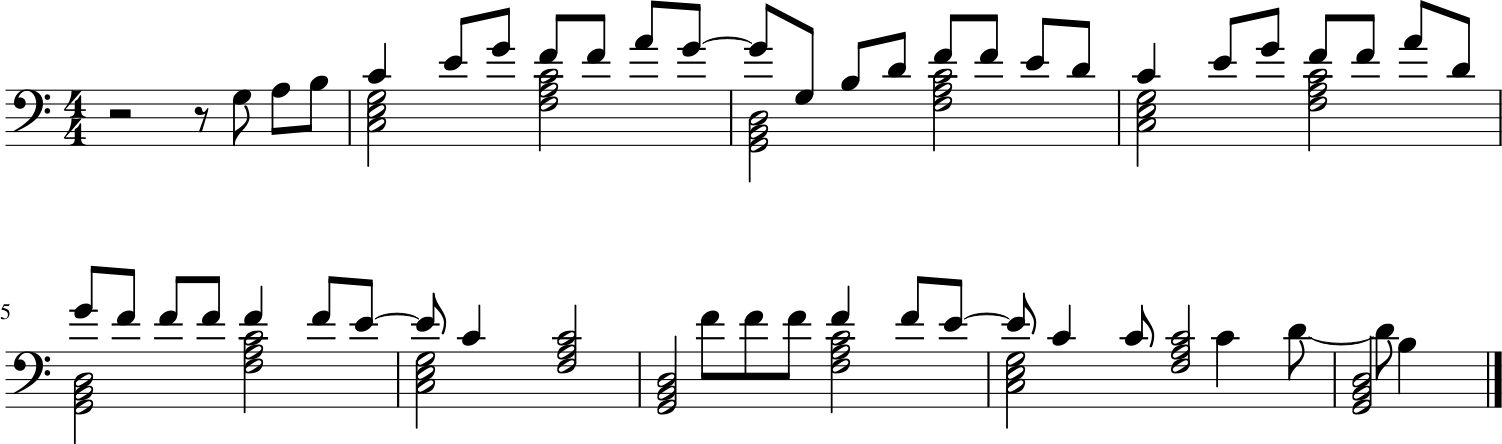

In [41]:
seed_stream = npenc2stream(seed_np)
seed_stream.show()

In [42]:
double = partial(to_double_stream, vocab=vocab)

In [79]:
out_s, seed_s = learn.predict(xb, n_words=400, temperatures=(1.1,0.8), min_p=1/128, min_bars=12)

Predicted BOS token. Returning prediction...


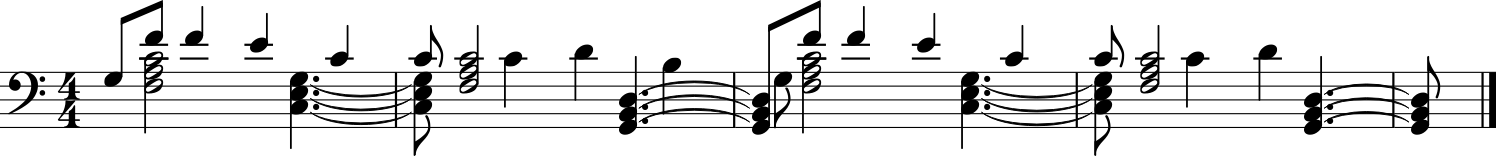

In [80]:
stream = npenc2stream(double(out_s))
stream.show()

In [81]:
out_s, seed_s = learn.predict_topk(xb, n_words=400, temperatures=(1.2,0.7), min_bars=12, top_k=40, top_p=0.9)

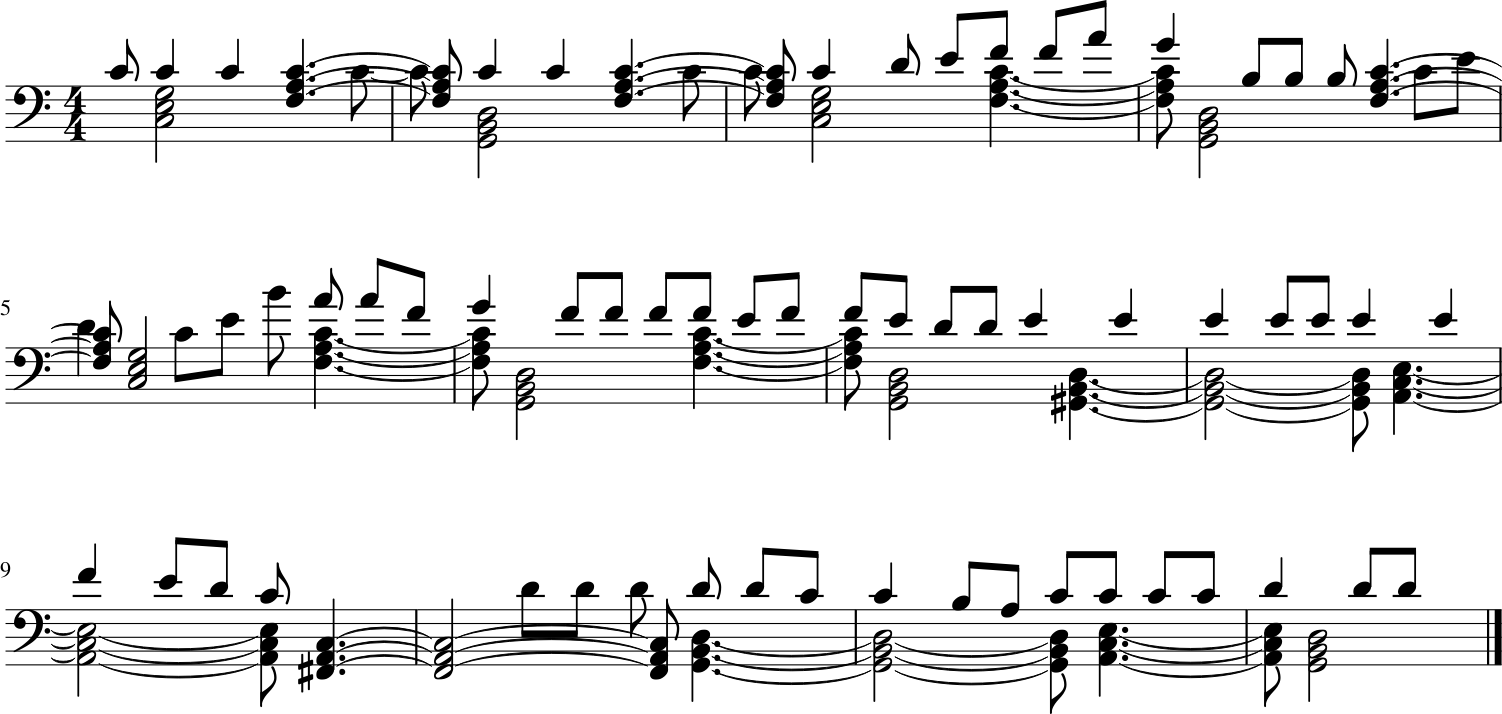

In [82]:
stream = npenc2stream(double(out_s))
stream.show()

In [83]:
stream.show('midi')

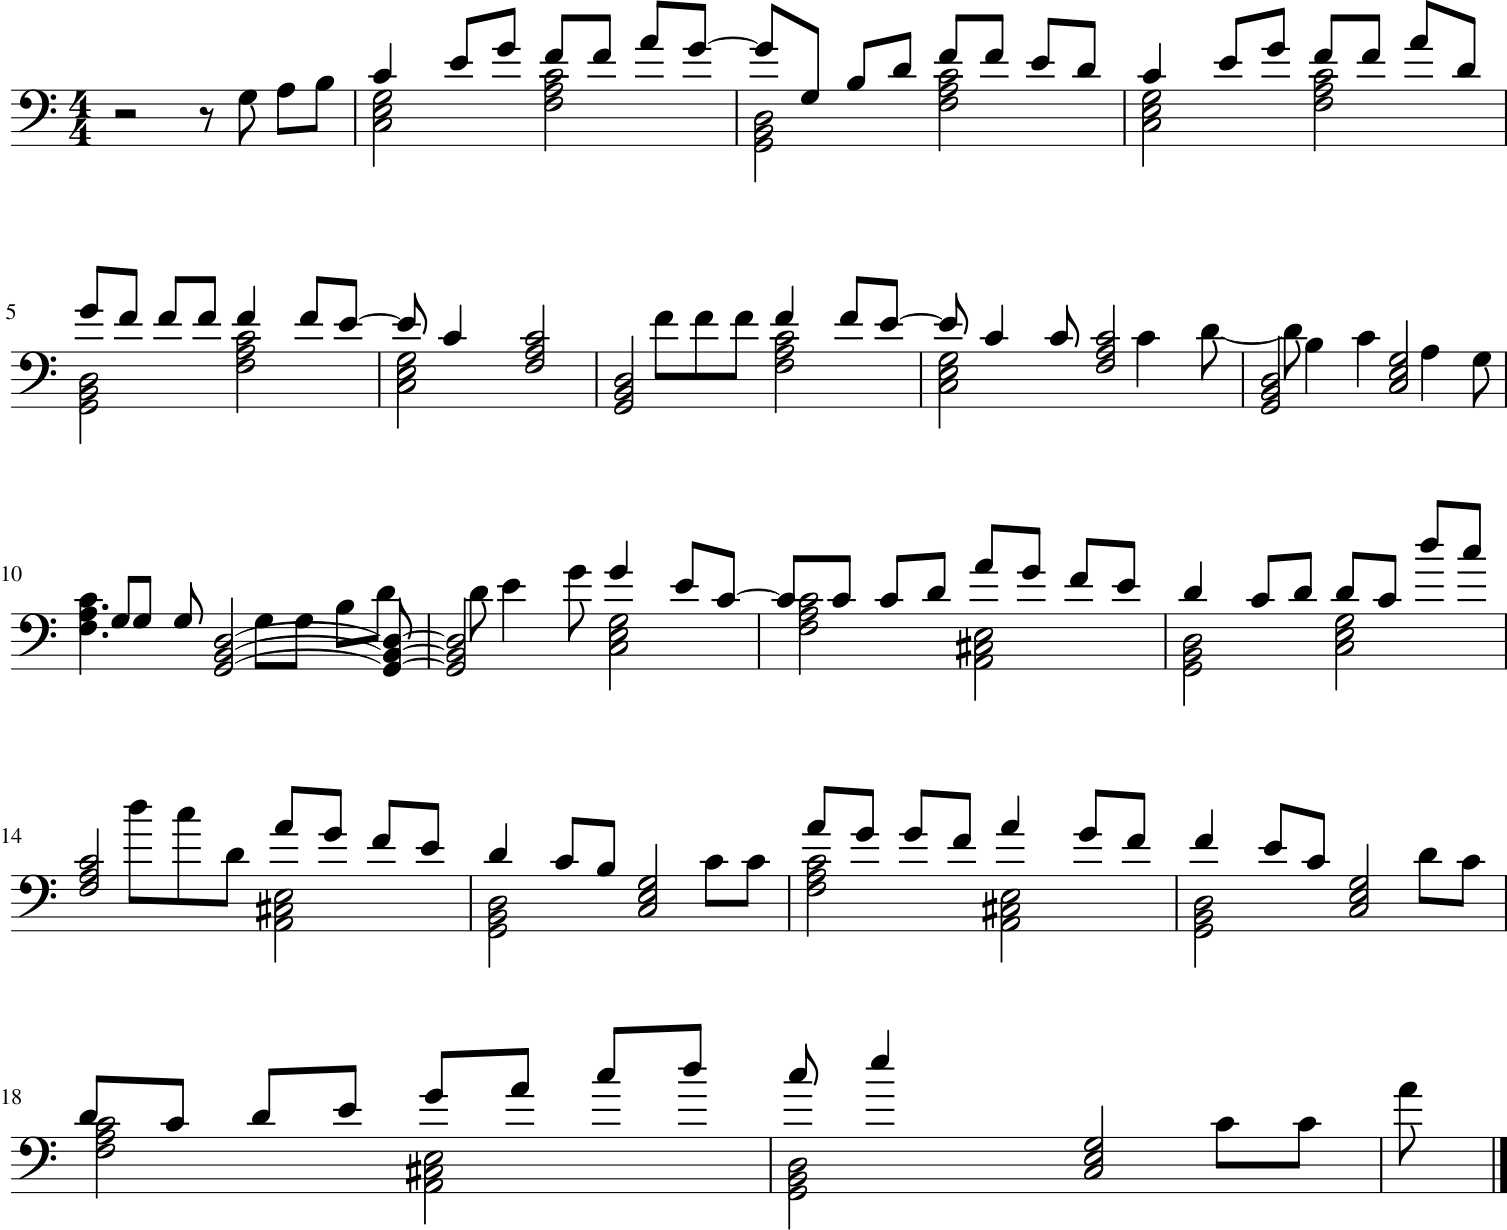

In [68]:
full_stream = npenc2stream(double(np.concatenate((seed_s,out_s), axis=-1)))
full_stream.show()

In [69]:
full_stream.show('midi')

## Prediction

In [33]:
x,y = data.one_batch(cpu=False)

In [34]:
out,seed = learn.predict(x, n_words=100)

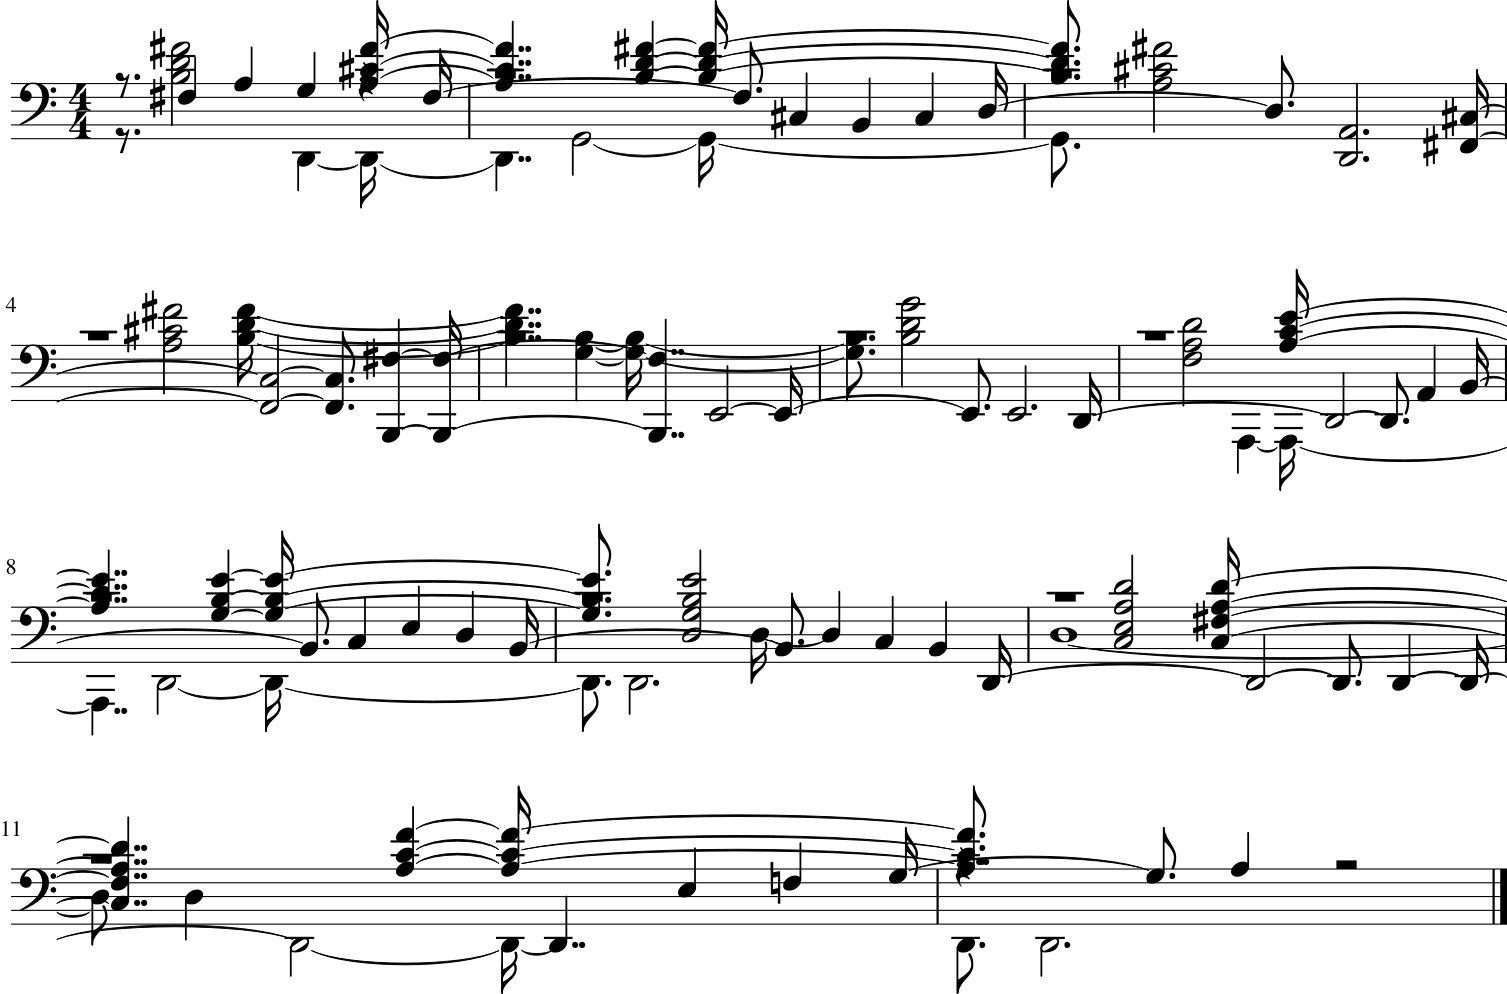

In [35]:
stream = npenc2stream(double(seed))
stream.show()

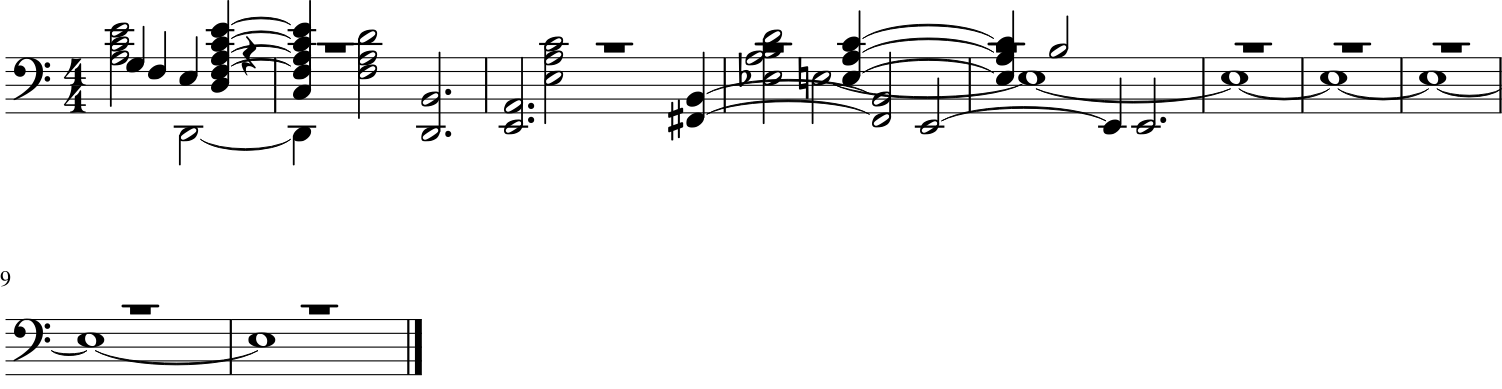

In [36]:
stream = npenc2stream(double(out))
stream.show()

In [ ]:
stream.show('midi')

### From song

In [37]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [38]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-cho

In [39]:
# file = np.random.choice(files)
file = search[-2]
file

PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/chorus_key_original.npy')

In [40]:
#good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [41]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [43]:
out, seed = learn.predict(xb, n_words=340, temperature=.7, min_p=0.01)

ValueError: too many values to unpack (expected 2)

### Actual prediction

In [59]:
seq = npenc2seq(np.array(out))
chordarr = seq2chordarr(seq)
stream = chordarr2stream(chordarr)

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


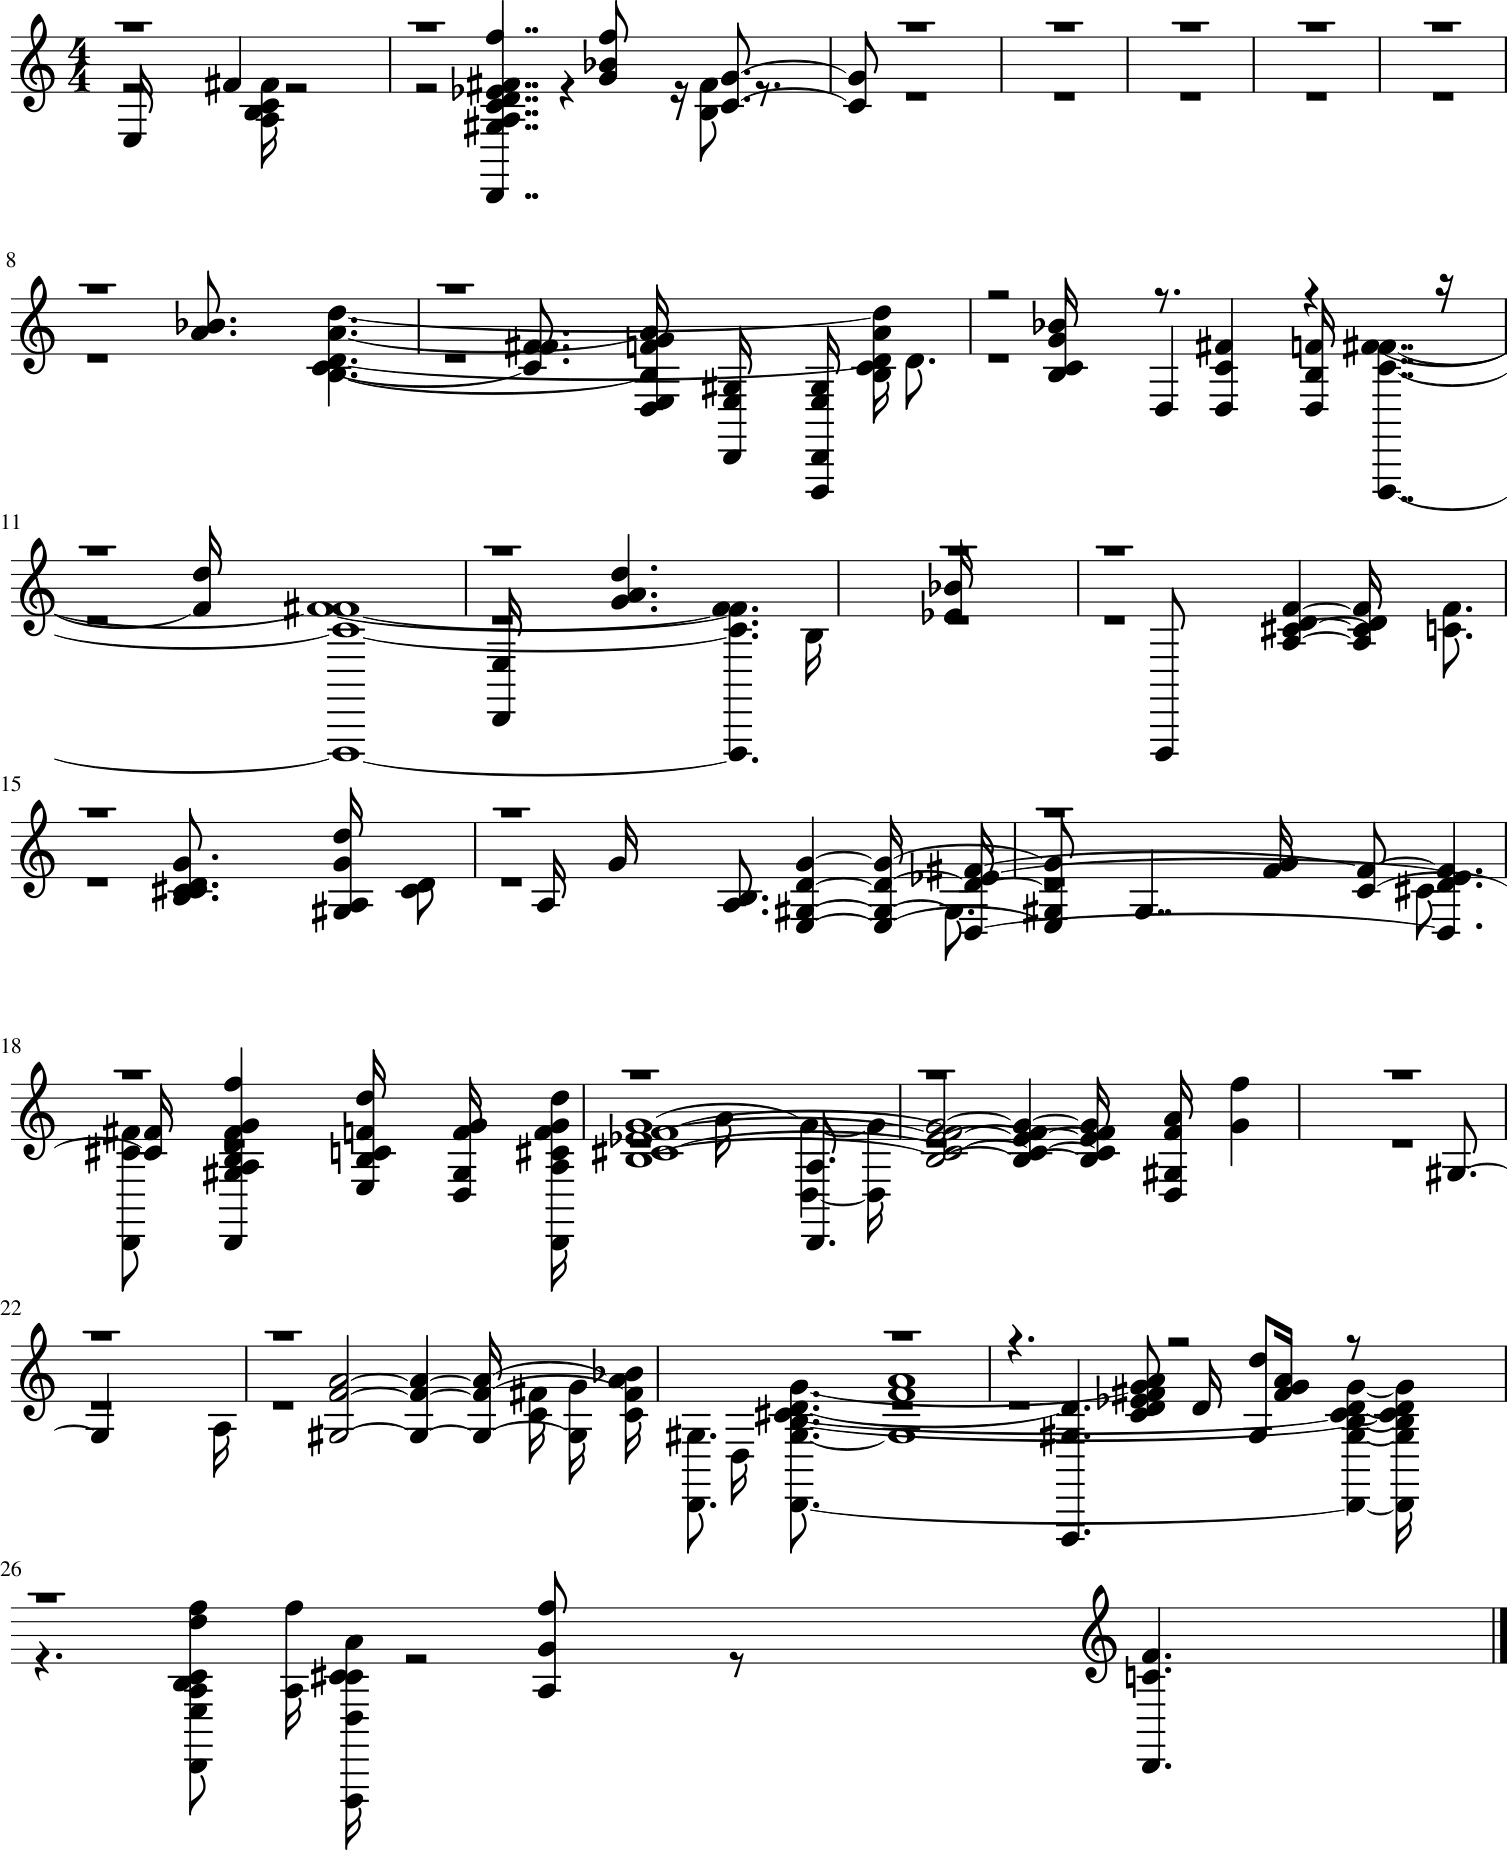

In [60]:
stream.show()

In [61]:
stream.show('midi')

## Seed

In [434]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

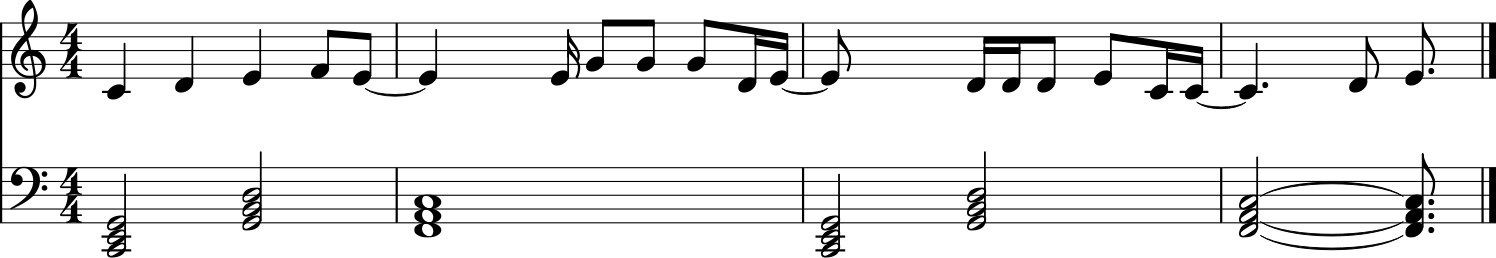

In [435]:
seed_stream.show()

In [436]:
seed_stream.show('midi')